Aplicação desenvolvida como resultado do Trabalho de Conclusão do Curso de Ciências Atuariais pela Universidade Federal de Pernambuco.
Seu objetivo consiste no cálculo de Provisões Matemáticas em planos de Benefício Definido para Entidades Fechadas de Previdência Complementar.

A aplicação está disponível no link: https://pyliability.onrender.com/

Qualquer sugestão de melhorias ou correções, contatar o responsável:
Hélder Belo
helder.belo@ufpe.br | helder@live.it

Importação de bibliotecas (pacotes)

In [31]:
#!pip install --upgrade pandas # para atualizar a versão do pandas

In [32]:
import numpy as np
import pandas as pd
import datetime as dt
from babel.numbers import format_currency
import time
elapsed_time = []

Definindo as Hipóteses Atuariais e características do plano de benefícios.

In [33]:
start_time = time.time() # Variável para computar o tempo de processamento

# Importando do GitHub o Banco de Tábuas Biométricas (Fonte: IBA)
banco_tabuas = pd.read_excel('https://github.com/helderbelo/tcc/blob/main/banco_tabuas.xlsx?raw=true', sheet_name='tabuas')

# Definindo as Hipóteses Atuariais e Características do Plano
mortalidade_geral_F = 'BR-EMSsb-v.2010-f' # Tábua de Mortalidade para o sexo feminino
mortalidade_geral_M = 'BR-EMSsb-v.2010-m' # Tábua de Mortalidade para o sexo masculino

#mortalidade_invalidos_F = 'WINKLEVOSS' # Hipótese a ser utilizada em aprimoramentos futuros
#mortalidade_invalidos_M = 'WINKLEVOSS' # Hipótese a ser utilizada em aprimoramentos futuros

entrada_invalidez = 'ALVARO VINDAS'

database = pd.to_datetime(dt.date(2022, 9, 30)) # DATA BASE DA AVALIAÇÃO (Ano, Mês, Dia)

#patrimonio_cobertura = 170,500,000.00 # Variável a ser utilizada em aprimoramentos futuros

idade_aposentadoria = 55        # Idade mínima de aposentadoria (em anos)
tempo_patrocinadora = 15        # Tempo mínimo de vinculação com a patrocinadora (em anos)
tempo_plano = 10                # Tempo mínimo de adesão ao plano  (em anos)

teto_salario_contribuicao = 15000   # Teto Salário Contribição / Participação (R$ 15.000,00)

perc_beneficio_salario = 80 /100    # Valor do Benefício (% do salário)
perc_reversao_pensao = 60 /100    # Reversão de Pensão (% do benefício)

i = 6 /100      # Taxa de Juros (%)
v = 1/(1+i)     # Fator de Descapitalização

idade_maxima_rotatividade = 48      # Última idade que considera probabilidade de desligamento
percentual_rotatividade = 1/100     # % Rotatividade (desligamento)

crescimento_salarial = 2.01 /100 # % Crescimento Real dos Salários a.a.

perc_contr_ativo = 5/100    # Contribuiçao Ativo (%)
perc_contr_patroc = 5/100   # Contribuiçao Patrocinadora (%)

tx_carregamento = 15/100    # Taxa de Carregamento (% da contrbuição)

#Composição Grupo Familiar
#per_casados_FEM = 100/100    # % de participantes femininas casadas (a ser utilizada em aprimoramentos futuros)
#per_casados_MAS = 100/100    # % de participantes masculinos casados (a ser utilizada em aprimoramentos futuros)

dif_conjuge = 4 # Homem 4 anos a mais que a mulher



Tratando o DataFrame para construir tabelas de múltiplos decrementos

In [34]:
#======== Tábua Feminina ===============

tabua_feminina = pd.DataFrame(None)

tabua_feminina['qx'] = banco_tabuas[[mortalidade_geral_F]].copy()   # definindo a tábua para a variável qx
tabua_feminina = tabua_feminina[tabua_feminina['qx'].notna()]       # excluindo as idades sem valores para qx (últimas idades pós idade ômega)

# utilizando a coluna índice para representar as idades 'x'
tabua_feminina.reset_index(inplace=True)
tabua_feminina.rename(columns={"index":"x"},inplace=True)

tabua_feminina['qxi'] =  0.0 #banco_tabuas[[mortalidade_invalidos_F]] # será utilizado em aprimoramentos futuros
tabua_feminina['ix'] = banco_tabuas[[entrada_invalidez]].copy().fillna(0)  # preenche os valores 'nan' com zeros

#======== Tábua Masculina ===============

# Repetindo o processo para a tábua masculina
tabua_masculina = pd.DataFrame(None)
tabua_masculina['qx'] = banco_tabuas[[mortalidade_geral_M]].copy()
tabua_masculina = tabua_masculina[tabua_masculina['qx'].notna()] 

tabua_masculina.reset_index(inplace=True)
tabua_masculina.rename(columns={"index":"x"},inplace=True)

tabua_masculina['qxi'] = 0.0 #banco_tabuas[[mortalidade_invalidos_M]]
tabua_masculina['ix'] = banco_tabuas[[entrada_invalidez]].copy().fillna(0)

#========== Idade ômega ============
w = max(tabua_feminina.x.values[-1],tabua_masculina.x.values[-1])

In [35]:
# Criando uma coluna para identificar cada tábua a ser utilizada quando juntar as duas em uma tábua única
tabua_masculina['id'] = 'M-'+tabua_masculina.x.astype(str)
tabua_feminina['id'] = 'F-'+tabua_masculina.x.astype(str)

Construção das probabilidades decrementais conforme expressões:

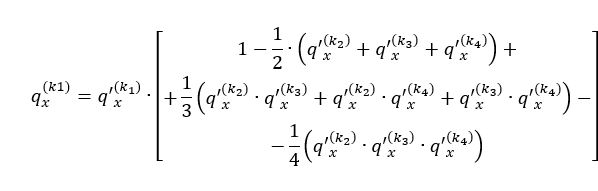



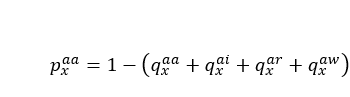

In [36]:
tabuas=[tabua_feminina,tabua_masculina]

for tabua in tabuas:
    # Rotatividade a partir dos 18 anos até idade máxima considerada na hipótese
    tabua.loc[18:idade_maxima_rotatividade,'wx'] = (np.array([percentual_rotatividade]*(idade_maxima_rotatividade-17))) 
    
    # Preenchendo as demais idades com zeros
    tabua['wx'] = tabua['wx'].fillna(0.0)
    
    # Decrementos sem hipóteses definidas nesse exemplo
    tabua['zx'] = 0.0
    tabua['qr'] = 0.0

    # px = 1 - qx
    tabua['px'] = 1-tabua.qx
    
    # Probabilidades em ambiente de 4 decrementos
    tabua['qx_ai'] = tabua.ix*(1 - 1/2*(tabua.qx + tabua.wx + tabua.qr) + 1/3*(tabua.qx * tabua.wx + tabua.qx * tabua.qr + tabua.wx * tabua.qr) - 1/4*(tabua.qx * tabua.wx * tabua.qr))
    tabua['qx_aw'] = tabua.wx*(1 - 1/2*(tabua.qx + tabua.ix + tabua.qr) + 1/3*(tabua.qx * tabua.ix + tabua.qx * tabua.qr + tabua.ix * tabua.qr) - 1/4*(tabua.qx * tabua.ix * tabua.qr))
    tabua['qx_ar'] = tabua.qr*(1 - 1/2*(tabua.qx + tabua.ix + tabua.wx) + 1/3*(tabua.qx * tabua.ix + tabua.qx * tabua.wx + tabua.ix * tabua.wx) - 1/4*(tabua.qx * tabua.ix * tabua.wx))
    tabua['qx_aa'] = tabua.qx*(1 - 1/2*(tabua.ix + tabua.wx + tabua.qr) + 1/3*(tabua.ix * tabua.wx + tabua.ix * tabua.qr + tabua.wx * tabua.qr) - 1/4*(tabua.ix * tabua.wx * tabua.qr))
    
    # px_aa = probabilidade do participante permanecer ativo = 1 - qx's
    tabua['px_aa'] = 1 - (tabua.qx_aa + tabua.qx_ai + tabua.qx_ar + tabua.qx_aw)

    # Criando as colunas lx's inicialmente com valor zero
    tabua['lx'] = tabua['lx_aa'] = 0.0
    
    # Atribuindo a raiz da tábua na idade zero
    tabua.loc[0,'lx'] = tabua.loc[0,'lx_aa'] = 100000

    # Calculando os lx a partir da idade 1 com base em lx-1 - qx-1 * lx-1
    for i in tabua.x[1:]:
        tabua.loc[i,'lx'] = tabua.lx[i-1] - tabua.qx[i-1] * tabua.lx[i-1]  
        tabua.loc[i,'lx_aa'] = tabua.lx_aa[i-1] * tabua.px_aa[i-1]

    tabua['dx'] = tabua.qx * tabua.lx
  
#tabua_feminina

Construção das funções de comutação:

$$
D_{x}=l_{x} \cdot v^{x},\ \ N_{x}=\sum_{t=0}^{\omega-x-1} D_{x+t},\ \ S_{x}=\sum_{t=0}^{\omega-x-1} N_{x+t}, \ \ \ddot{a}_{x}=\sum_{t=0}^{\omega-x-1}{ }_{t} p_{x} \cdot v^{t}=\frac{N_{x}}{D_{x}}
$$


$$
\begin{gathered}
D_{x}^{a a}=l_{x}^{a a} \cdot v^{x}, \text { em que } l_{x}^{a a}=l_{x-1}^{a a} \cdot p_{x-1}^{a a} ; \ \
N_{x}^{a a}=\sum_{t=0}^{\omega-x} D_{x+t}^{a a} ; \ \
\ddot{a}_{x}^{a a}=\frac{N_{x}^{a a}}{D_{x}^{a a}} .
\end{gathered}
$$

\\
Renda reversível (para cálculo da reversão em pensão do benefício de aposentadoria):
$$
\ddot{a}_{x \mid y}=\ddot{a}_{y}-\ddot{a}_{x, y} , \text{ em que } { }_{n} p_{y}=\frac{l_{y+n}}{l_{y}} \ \text { e } \ _{n} p_{x, y}=\frac{l_{x+n} \cdot l_{y+n}}{l_{x} \cdot l_{y}}
$$


In [37]:
# Para construir os valores das rendas conjuntas 
tabua_feminina['lxy'] = tabua_feminina.lx * tabua_masculina.lx.shift(-dif_conjuge) # No caso da tábua feminina, está pegando o lx da tábua do cônjuge deslocado a diferença de idade para mais
tabua_masculina['lxy'] = tabua_feminina.lx.shift(dif_conjuge) * tabua_masculina.lx

tabuas=[tabua_feminina,tabua_masculina]

for tabua in tabuas:
    
    tabua['Dx'] = tabua.lx * v ** tabua.x
    tabua['Dx_aa'] = tabua.lx_aa * v ** tabua.x    
    tabua['Dxy'] = tabua.lxy * v ** tabua.x

    tabua['Nx']=tabua['Nxy']=tabua['Nx_aa']=0.00
    for x in tabua.x:            
      tabua.loc[x,'Nx'] = tabua.loc[x:,'Dx'].sum()
      tabua.loc[x,'Nx_aa'] = tabua.loc[x:,'Dx_aa'].sum()
      tabua.loc[x,'Nxy'] = tabua.loc[x:,'Dxy'].sum()
      tabua['Sx'] = tabua.loc[x:,'Nx'].sum()
    
    tabua['äx'] = tabua.Nx/tabua.Dx
    tabua['äx_aa'] = tabua.Nx_aa/tabua.Dx_aa
    tabua['äxy'] = tabua.Nxy / tabua.Dxy

In [38]:
#Importando a base de beneficiários
ativos = pd.read_excel('https://github.com/helderbelo/tcc/blob/main/base-bd.xlsx?raw=true', sheet_name='ativos')
aposentados = pd.read_excel('https://github.com/helderbelo/tcc/blob/main/base-bd.xlsx?raw=true', sheet_name='aposentados')
pensionistas = pd.read_excel('https://github.com/helderbelo/tcc/blob/main/base-bd.xlsx?raw=true', sheet_name='pensionistas')

In [39]:
# Base maior para teste de performance com 1 milhão de registros
#ativos = pd.read_csv('https://github.com/helderbelo/tcc/blob/main/base_ativos_teste.csv?raw=true')

# Base com 200.000 registros da base maior
#ativos = ativos.iloc[:200000,:]

Operações com datas para apurar idade, tempo de patrocinadora, plano e elegibildiade para da aposentadoria. \\
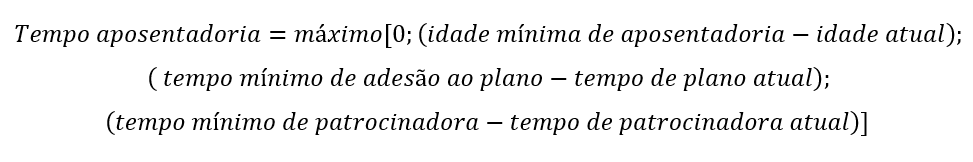

In [40]:
colunas_datas=['DT NASC','DT ADMISSÃO','DT ADESÃO']

# Transformando as colunas de datas em formato de data reconhecível pelo python (caso precise)
for i in colunas_datas:
    ativos[i] = pd.to_datetime(ativos[i])

# Idade Atual na Data Base dos Cálculos
ativos['IDADE_x'] = (database - ativos['DT NASC']).astype('timedelta64[Y]').astype(int)                

# Idade de Adesão
ativos['IDADE_e'] = (ativos['DT ADESÃO'] - ativos['DT NASC']).astype('timedelta64[Y]').astype(int)     

# Tempo na Patrocinadora na Data Base em anos
ativos['TEMP_PATROC'] = (database - ativos['DT ADMISSÃO']).astype('timedelta64[Y]').astype(int)         

# Tempo no Plano na Data Base em anos
ativos['TEMP_PLANO'] = (database - ativos['DT ADESÃO']).astype('timedelta64[Y]').astype(int)            

# Tempo para estar elegível para aposentadoria em anos
ativos['TEMP_APOSENT'] = np.maximum(0,
                                    np.maximum(idade_aposentadoria - ativos['IDADE_x'],    # Critério de idade
                                    np.maximum(tempo_plano - ativos['TEMP_PLANO'],          # Critério de Tempo de Adesão ao Plano
                                    tempo_patrocinadora - ativos['TEMP_PATROC'])))          # Critério de Tempo na Patrocinadora

# Idade na elegibilidade  para aposentadoria em anos
ativos['IDADE_APOSENT'] = ativos['IDADE_x'] + ativos['TEMP_APOSENT']


Cálculo do sálario de participação, salário projetado e do benefício de aposentadoria programada.

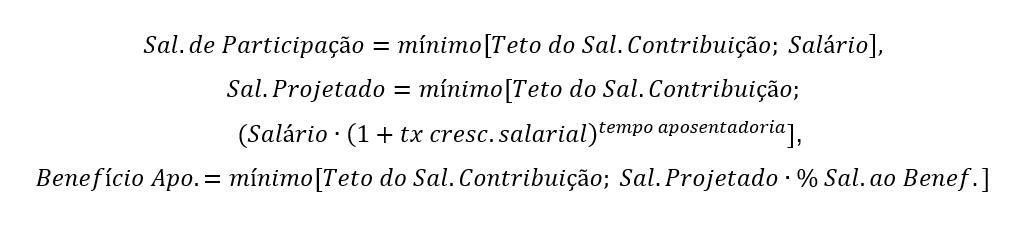

In [41]:
# Salário de Participação = Mínimo entre Teto de Contribuição ou Salário
ativos['SALARIO_PARTICIPACAO'] = np.minimum(teto_salario_contribuicao , ativos['SALARIO'])

# Salário na Aposentadoria = Mínimo entre Teto de Contribuição ou Salário Projetado
ativos['SALARIO_APOSENT'] = np.minimum(teto_salario_contribuicao , ativos['SALARIO'] * (1+crescimento_salarial) ** ativos['TEMP_APOSENT'])

# Benefício na Aposentadoria = Mínimo entre Teto de Contribuição ou Salário Projetado x % do salário para o benefício
ativos['BENEFICIO_z'] = np.minimum(teto_salario_contribuicao , ativos['SALARIO_APOSENT'] * perc_beneficio_salario)


Atribuindo sexo e idade do cônjuge conforme premissa adotada.

In [42]:
# Sexo do conjuge com base no sexo oposto
ativos['SEXO_CONJUGE'] = np.where(ativos.SEXO == 'M', 'F', 'M')

# Idade do conjuge com base nas premissas
ativos['IDADE_CONJUGE'] = np.where(ativos.SEXO == 'M', ativos.IDADE_x - dif_conjuge, ativos.IDADE_x + dif_conjuge)

#ativos

Criação da tábua única para consulta das anuidades.

In [43]:
# Unindo as duas tábuas de mortalidade (inserindo novas linhas)
tabua_unica = pd.concat([tabua_masculina,tabua_feminina])
tabua_unica.tail(10)

,x,qx,qxi,ix,id,wx,zx,qr,px,qx_ai,...,Dx,Dx_aa,Dxy,Nx,Nxy,Nx_aa,Sx,äx,äx_aa,äxy
107,107,0.47011,0.0,0.0,F-107,0.0,0.0,0.0,0.52989,0.0,...,1.238028e+00,9.453133e-02,19.596973,2.313243e+00,23.119551,1.766309e-01,7.141762e-07,1.868490,1.868490,1.179751
108,108,0.51562,0.0,0.0,F-108,0.0,0.0,0.0,0.48438,0.0,...,6.188856e-01,4.725586e-02,3.131436,1.075215e+00,3.522578,8.209954e-02,7.141762e-07,1.737341,1.737341,1.124908
109,109,0.56553,0.0,0.0,F-109,0.0,0.0,0.0,0.43447,0.0,...,2.828074e-01,2.159414e-02,0.363132,4.563298e-01,0.391142,3.484368e-02,7.141762e-07,1.613571,1.613571,1.077134
110,110,0.62029,0.0,0.0,F-110,0.0,0.0,0.0,0.37971,0.0,...,1.159163e-01,8.850950e-03,0.027016,1.735224e-01,0.028010,1.324954e-02,7.141762e-07,1.496963,1.496963,1.036793
111,111,0.68035,0.0,0.0,F-111,0.0,0.0,0.0,0.31965,0.0,...,4.152320e-02,3.170561e-03,0.000989,5.760608e-02,0.000994,4.398591e-03,7.141762e-07,1.387323,1.387323,1.004611
112,112,0.74623,0.0,0.0,F-112,0.0,0.0,0.0,0.25377,0.0,...,1.252159e-02,9.561035e-04,0.000005,1.608288e-02,0.000005,1.228030e-03,7.141762e-07,1.284412,1.284412,1.000000
113,113,0.81849,0.0,0.0,F-113,0.0,0.0,0.0,0.18151,0.0,...,2.997741e-03,2.288966e-04,NaN,3.561287e-03,0.000000,2.719269e-04,7.141762e-07,1.187990,1.187990,NaN
114,114,0.89776,0.0,0.0,F-114,0.0,0.0,0.0,0.10224,0.0,...,5.133207e-04,3.919530e-05,NaN,5.635461e-04,0.000000,4.303033e-05,7.141762e-07,1.097844,1.097844,NaN
115,115,0.98471,0.0,0.0,F-115,0.0,0.0,0.0,0.01529,0.0,...,4.951123e-05,3.780498e-06,NaN,5.022541e-05,0.000000,3.835030e-06,7.141762e-07,1.014425,1.014425,NaN
116,116,1.00000,0.0,0.0,F-116,0.0,0.0,0.0,0.00000,0.0,...,7.141762e-07,5.453190e-08,NaN,7.141762e-07,0.000000,5.453190e-08,7.141762e-07,1.000000,1.000000,NaN


In [44]:
# Obtenção dos valores das funções de comutação com base no sexo e idade de aposentadoria

ativos['id'] =  ativos.SEXO+"-"+ativos.IDADE_APOSENT.astype(str)    # Criando uma coluna chave para dar match na tábua única de múltiplos decrementos
ativos = ativos.merge(tabua_unica[['id','Dx_aa','äx','äxy']], on='id',how='left') # Unindo a base de ativos com os valores das funções de comutação
ativos.rename(columns={'äx':'äz','Dx_aa':'Dz_aa',},inplace=True)  # Renomeando a coluna para Dz_aa e äz (Renda antecipada vitalícia a partir da data de aposentadoria)
ativos.drop(columns='id',inplace=True)  # Excluindo a coluna de chave única
#ativos

In [45]:
#Trazendo os valores das funções de comutação com base no sexo e idade de atual

ativos['id'] =  ativos.SEXO+"-"+ativos.IDADE_x.astype(str)  # Criando uma chave única para dar match na tábua multidecremental unificada, dessa vez com a idade atual
ativos = ativos.merge(tabua_unica[['id','qx_ai','qx_aa','Dx_aa']], on='id',how='left')
ativos.drop(columns='id',inplace=True)
#ativos

In [46]:
#Trazendo os valores das funções de comutação com base no sexo do cônjuge e idade de cônjuge na aposentadoria do beneficiário

ativos['id'] =  ativos.SEXO_CONJUGE+"-"+(ativos.TEMP_APOSENT + ativos.IDADE_CONJUGE).astype(str)

ativos = ativos.merge(tabua_unica[['id','äx']], on='id',how='left')
ativos.rename(columns={'äx':'äy'},inplace=True) # Renomeando a coluna para äy (Renda antecipada vitalícia para o cônjuge a partir da data de aposentadoria do beneficiário)
ativos.drop(columns='id',inplace=True)
#ativos

In [47]:
# Valor Atual dos Benefícios Futuros de Aposentadoria
# 13 pagamentos mensais x Valor do Benefício x Valor da Renda Vitalícia x nEx (Data de Aposentadoria / Data Atual)
ativos['VABF_APO'] = 13 * ativos['BENEFICIO_z'] * ativos['äz'] * ativos.Dz_aa/ativos.Dx_aa

# Valor Atual dos Benefícios Futuros Pecúlio por Invalidez 
# Maior valor entre o valor do Resgate ou 15x o valor do salário de participação x decremento de invalidez
ativos['VABF_INV'] =  np.maximum(ativos['RESGATE'], 15 * ativos['SALARIO_PARTICIPACAO']) * ativos['qx_ai']

# Valor Atual dos Benefícios Futuros Pecúlio por Morte
# Maior valor entre o valor do Resgate ou 15x o valor do salário de participação x decremento de morte
ativos['VABF_PEC'] =  np.maximum(ativos['RESGATE'], 15 * ativos['SALARIO_PARTICIPACAO']) * ativos['qx_aa']

# Valor Atual dos Benefícios Futuros de Aposentadoria com Reversão em Pensão
# 13 pagamentos mensais x Valor do Benefício x Diferença Valor da Renda Vitalícia do Cônjuge e da Renda Conjunta x nEx
ativos['VABF_REV_PENS'] = 13 * perc_reversao_pensao * ativos.BENEFICIO_z * (ativos.äy - ativos.äxy) * ativos.Dz_aa/ativos.Dx_aa

In [48]:
# Variável para armazenar os anos t de zero à idade de aposentadoria
fluxo = list(np.arange(0,1+max(ativos.TEMP_APOSENT)))

Cálculo do Valor Atual (Valor Presente Esperado) dos Salários Futuros conforme expressão:

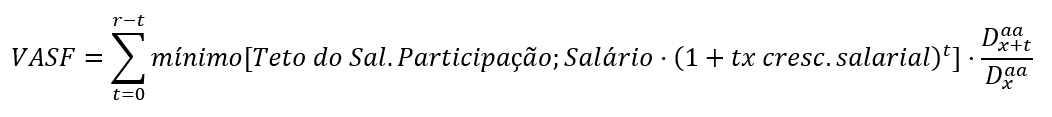

In [49]:
# Cálculo do nEx nos anos futuros com base na idade atual para ser utilizado no cálculo do Valor Atual dos Salários Futuros

# Criando uma cópia da base apenas com as colunas desejáveis
nEx_aa = ativos[['MATRICULA','SEXO','IDADE_x','IDADE_APOSENT','SALARIO']].copy()

for t in fluxo:
    nEx_aa['id'] = np.where(nEx_aa.IDADE_x+t <= nEx_aa.IDADE_APOSENT,   # Condição para trazer o valor do nEx apenas até a data de aposentadoria
                            nEx_aa.SEXO+"-"+(nEx_aa.IDADE_x+t).astype(str), # Criando chave única para cada t ano 
                            'N/A')   # Não se aplica para idades após aposentadoria
    
    nEx_aa = nEx_aa.merge(tabua_unica[['id','Dx_aa']], on='id',how='left')
    nEx_aa.rename(columns={'Dx_aa':t},inplace=True)
    
    nEx_aa[t] = nEx_aa[t] / ativos.Dx_aa # nEx = Dx+n / Dx

nEx_aa.drop(columns='id',inplace=True)
nEx_aa.head(10)


,MATRICULA,SEXO,IDADE_x,IDADE_APOSENT,SALARIO,0,1,2,3,4,...,16,17,18,19,20,21,22,23,24,25
0,1,M,59,59,18844.5,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,M,67,67,20604.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,M,59,59,12665.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,M,68,68,9401.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,F,54,55,5652.5,1.0,0.938881,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,M,52,55,19764.0,1.0,0.938101,0.879567,0.824195,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,M,60,60,6375.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,M,57,57,15376.5,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,M,44,55,20247.0,1.0,0.931202,0.866949,0.806930,0.750861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,M,43,55,18445.0,1.0,0.931382,0.867305,0.807461,0.751560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Apenas visualização dos dados
nEx_aa.iloc[:,5:]

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,0.938881,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,0.931000,0.866547,0.806336,0.750077,0.704554,0.661538,0.620886,0.582453,0.546110,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,1.0,0.932888,0.870224,0.811723,0.757100,0.706099,0.658478,0.614008,0.572475,0.533685,...,0.331558,0.311677,0.292883,0.275110,0.258295,NaN,NaN,NaN,NaN,NaN
97,1.0,0.932149,0.868814,0.809687,0.754490,0.702959,0.654839,0.609905,0.567945,0.528756,...,0.330801,0.310160,0.290635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,1.0,0.933002,0.870463,0.812077,0.757577,0.706690,0.659182,0.614824,0.573407,0.534735,...,0.326829,0.304416,0.286333,0.269251,0.253106,0.237843,0.22341,0.209756,NaN,NaN


In [51]:
# Criando outro dataframe com o salário projetado com base nas premissas

vasf = ativos[['MATRICULA','SEXO','IDADE_x','IDADE_APOSENT','SALARIO']].copy()
vasf = vasf.reindex(columns=['MATRICULA','SEXO','IDADE_x','IDADE_APOSENT','SALARIO'] + fluxo)

for t in fluxo:
    
    vasf.loc[:,t] = (np.where(
        t + vasf['IDADE_x'] > vasf['IDADE_APOSENT'],
        0.00,np.minimum( teto_salario_contribuicao,
                   vasf['SALARIO']*(1+crescimento_salarial) ** t)))

vasf.head(10)

,MATRICULA,SEXO,IDADE_x,IDADE_APOSENT,SALARIO,0,1,2,3,4,...,16,17,18,19,20,21,22,23,24,25
0,1,M,59,59,18844.5,15000.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,M,67,67,20604.0,15000.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,M,59,59,12665.0,12665.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,M,68,68,9401.0,9401.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,F,54,55,5652.5,5652.5,5766.11525,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,M,52,55,19764.0,15000.0,15000.00000,15000.0,15000.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,M,60,60,6375.0,6375.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,M,57,57,15376.5,15000.0,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,M,44,55,20247.0,15000.0,15000.00000,15000.0,15000.0,15000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,M,43,55,18445.0,15000.0,15000.00000,15000.0,15000.0,15000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# Valor Atual dos Salários Futuros = Salários Projetado x Desconto Atuarial (nEX)

vasf.iloc[:,5:] = vasf.iloc[:,5:] * nEx_aa.iloc[:,5:]

vasf.iloc[:,5:]

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12665.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9401.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5652.5,5413.694675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5865.0,5570.067696,5288.657866,5020.097172,4763.703731,4564.528587,4371.989282,4185.804555,4005.632257,3831.185785,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,5227.5,4974.690848,4733.809490,4504.330517,4285.667126,4077.304601,3878.750154,3689.499246,3509.074802,3337.055970,...,2383.072718,2285.203851,2190.570615,2098.997872,2010.319965,NaN,NaN,NaN,NaN,NaN
97,1632.0,1551.845199,1475.476487,1402.701683,1333.352136,1267.254845,1204.233954,1144.146578,1086.846178,1032.192120,...,742.285781,709.959016,678.636226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,4777.0,4546.537139,4327.041264,4117.948474,3918.798773,3729.045158,3548.273740,3376.022267,3211.885272,3055.474563,...,2146.643615,2039.621100,1957.027178,1877.258854,1800.162929,1725.615863,1653.479691,1583.623918,NaN,NaN


Cálculo da PMBaC pelo método Crédito Unitário Projetado e do Valor Atual (Valor Presente Esperado) das Contribuições Futuras.

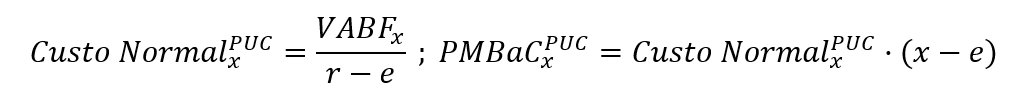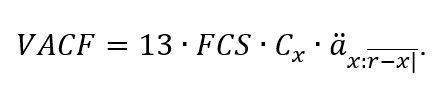

In [53]:
# Valor Atual dos Salários Futuros está pegando a soma de todas as colunas para cada linha
ativos['VASF'] = vasf.iloc[:,5:].sum(axis=1)

# Valor Atual das Contribuições Futuras = (% de contribuição ativo + patrocinadora) x (1-taxa de carregamento) x Valor Atual dos Salários Futuros
ativos['VACF'] = 13 * (perc_contr_ativo + perc_contr_patroc) * (1 - tx_carregamento) * ativos['VASF']

# Custo Normal pelo Médoto Crédito Unitário = Soma dos Valores Atuais dos Benefícios Futuros / diferença entre idade de aposentadoria e idade de adesão
ativos['CN'] = (ativos.VABF_APO + ativos.VABF_INV + ativos.VABF_PEC + ativos.VABF_REV_PENS) / (ativos.IDADE_APOSENT - ativos.IDADE_e)

# Provisões Matemáticas dos Benefícios a Conceder Método Crédito Unitário = Custo Normal x diferença entre idade x e idade de adesão
ativos['PMBaC_UC'] = ativos.CN * (ativos.IDADE_x - ativos.IDADE_e)

# Custo Normal de contribução anual ao plano
ativos['CN_CONTRIB_PLANO'] = 13 * ativos.SALARIO_PARTICIPACAO * (perc_contr_ativo + perc_contr_patroc) * (1 - tx_carregamento)
ativos

,MATRICULA,DT NASC,DT ADMISSÃO,DT ADESÃO,SEXO,SALARIO,RESGATE,IDADE_x,IDADE_e,TEMP_PATROC,...,äy,VABF_APO,VABF_INV,VABF_PEC,VABF_REV_PENS,VASF,VACF,CN,PMBaC_UC,CN_CONTRIB_PLANO
0,1,1962-10-15,1980-02-15,1983-03-15,M,18844.5,289620.5,59,20,42,...,14.660037,2.048374e+06,1413.418005,1742.137273,212977.821948,15000.000000,16575.000000,58064.292941,2.264507e+06,16575.0000
1,2,1955-02-17,1981-05-15,1981-06-06,M,20604.0,453101.0,67,26,41,...,13.305011,1.780270e+06,5893.857904,5446.647217,262313.390837,15000.000000,16575.000000,50095.709708,2.053924e+06,16575.0000
2,3,1963-05-17,1983-11-18,1983-11-18,M,12665.0,177650.0,59,20,38,...,14.660037,1.729510e+06,927.123893,1142.745518,179824.274331,12665.000000,13994.825000,49010.375158,1.911405e+06,13994.8250
3,4,1954-03-12,1986-02-22,1986-02-22,M,9401.0,178211.0,68,31,36,...,13.107670,1.092280e+06,2628.396097,2340.228910,167851.446091,9401.000000,10388.105000,34191.891697,1.265100e+06,10388.1050
4,5,1968-02-05,1990-03-18,1990-03-18,F,5652.5,44591.0,54,22,32,...,13.130603,8.253957e+05,233.945379,171.880929,25199.936682,11066.194675,12228.145116,25787.921620,8.252135e+05,6246.0125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,1977-02-07,2016-02-15,2016-02-21,M,5865.0,47549.0,45,39,6,...,15.194066,5.273941e+05,102.663643,174.967656,45771.417221,51128.824051,56497.350576,35840.195057,2.150412e+05,6480.8250
96,97,1987-02-14,2012-08-24,2017-05-12,F,5227.5,43375.5,35,30,10,...,13.130603,3.065022e+05,53.119453,36.657141,9357.737900,70041.474451,77395.829268,12637.988782,6.318994e+04,5776.3875
97,98,1985-08-22,2018-05-25,2018-07-16,M,1632.0,6664.0,37,32,4,...,15.194066,9.773167e+04,17.818994,29.461927,8481.924953,20485.719658,22636.720222,4620.037986,2.310019e+04,1803.3600
98,99,1989-11-15,2019-03-22,2019-03-22,F,4777.0,7089.0,32,29,3,...,13.130603,2.414463e+05,44.765403,28.509750,7371.531803,68825.553594,76052.236722,9572.733075,2.871820e+04,5278.5850


In [54]:
print(
'PMBaC',

'\nVABF - Aposentadoria:',  format_currency(ativos.VABF_APO.sum(), 'BRL', locale='pt_BR'),
'\nVABF - Reversão em Pensão:', format_currency(ativos.VABF_REV_PENS.sum(), 'BRL', locale='pt_BR'),
'\nVABF - Invalidez:', format_currency(ativos.VABF_INV.sum(), 'BRL', locale='pt_BR'),
'\nVABF - Pecúlio:', format_currency(ativos.VABF_PEC.sum(), 'BRL', locale='pt_BR'),
'\n---------------------------------------------',
'\nTOTAL VABF:',  format_currency(ativos.VABF_APO.sum()+ativos.VABF_REV_PENS.sum()+ativos.VABF_INV.sum()+ativos.VABF_PEC.sum(), 'BRL', locale='pt_BR')


)

PMBaC 
VABF - Aposentadoria: R$ 86.984.974,10 
VABF - Reversão em Pensão: R$ 6.570.971,81 
VABF - Invalidez: R$ 37.920,59 
VABF - Pecúlio: R$ 45.963,02 
--------------------------------------------- 
TOTAL VABF: R$ 93.639.829,52


Repetindo algumas operações com os assistidos (inativos e pensionistas)

In [55]:
aposentados['IDADE_x'] = (database - aposentados['DT NASC']).astype('timedelta64[Y]').astype(int)     

# Sexo do conjuge com base no sexo oposto
aposentados['SEXO_CONJUGE'] = np.where(aposentados.SEXO == 'M', 'F', 'M')

# Idade do conjuge com base nas premissas
aposentados['IDADE_CONJUGE'] = np.where(aposentados.SEXO == 'M',aposentados.IDADE_x-dif_conjuge,aposentados.IDADE_x+dif_conjuge)

aposentados['id'] =  np.where(aposentados.SEXO_CONJUGE == 'M',      #Se o sexo do cônjuge = Masculino, adicionará/subtrairá idade do aposentado conforme premissa 
                              aposentados.SEXO_CONJUGE+"-"+(aposentados.IDADE_x+dif_conjuge).astype(str),
                              aposentados.SEXO_CONJUGE+"-"+(aposentados.IDADE_x-dif_conjuge).astype(str))

aposentados = aposentados.merge(tabua_unica[['id','äx']], on='id',how='left')
aposentados.rename(columns={'äx':'äy'},inplace=True)
aposentados.drop(columns='id',inplace=True)

#==================================================

aposentados['id'] =  aposentados.SEXO+"-"+aposentados.IDADE_x.astype(str)

aposentados = aposentados.merge(tabua_unica[['id','äx','äxy']], on='id',how='left')
aposentados.drop(columns='id',inplace=True)

aposentados['PMBC_APO'] = 13 * aposentados.BENEFICIO * aposentados['äx']

aposentados['PMBC_REV_PENS'] =  13 * perc_reversao_pensao * aposentados.BENEFICIO * (aposentados.äy - aposentados.äxy)

aposentados

,MATRICULA,DT NASC,DIB,SEXO,BENEFICIO,IDADE_x,SEXO_CONJUGE,IDADE_CONJUGE,äy,äx,äxy,PMBC_APO,PMBC_REV_PENS
0,101,1946-11-03,2002-12-31,M,6570,75,F,71,11.532963,9.364586,8.362920,7.998293e+05,162452.063202
1,102,1934-05-28,1992-08-08,M,4635,88,F,84,7.617161,5.782121,4.775943,3.484017e+05,102718.540784
2,103,1942-12-22,1997-12-22,F,2583,79,M,83,7.146398,9.275984,6.129286,3.114783e+05,20492.152957
3,104,1949-08-26,2019-01-03,M,3987,73,F,69,12.019678,9.900499,8.914539,5.131528e+05,96565.466180
4,105,1950-05-28,1996-05-21,M,1323,72,F,68,12.251439,10.163285,9.186799,1.747983e+05,31625.244736
5,106,1939-12-27,2017-08-02,M,12465,82,F,78,9.586761,7.425016,6.407197,1.203187e+06,309139.449703
6,107,1952-11-07,2012-02-02,F,9216,69,M,73,9.900499,12.019678,8.914539,1.440054e+06,70875.514577
7,108,1950-06-19,1997-11-13,F,1044,72,M,76,9.092221,11.278402,8.084752,1.530705e+05,8204.021402
8,109,1962-10-17,2008-10-01,M,1386,59,F,55,14.660037,13.130603,12.384633,2.365872e+05,24598.938435
9,110,1953-01-17,2014-10-21,M,14256,69,F,65,12.903941,10.926762,9.986566,2.025035e+06,324402.743727


In [56]:
pensionistas['IDADE_x'] = (database - pensionistas['DT NASC']).astype('timedelta64[Y]').astype(int)     

pensionistas['id'] =  pensionistas.SEXO+"-"+pensionistas.IDADE_x.astype(str)

pensionistas = pensionistas.merge(tabua_unica[['id','äx']], on='id',how='left')
pensionistas.drop(columns='id',inplace=True)

pensionistas['PMBC_PENS'] = 13 * pensionistas.BENEFICIO * pensionistas['äx']

pensionistas

,MATRICULA,DT NASC,DIB,SEXO,BENEFICIO,IDADE_x,äx,PMBC_PENS
0,201,1949-05-21,2002-10-26,F,330,73,11.016508,4.726082e+04
1,202,1957-06-24,2020-03-27,F,880,65,12.903941,1.476211e+05
2,203,1953-05-25,2012-05-20,F,1120,69,12.019678,1.750065e+05
3,204,1940-03-24,1998-01-20,F,680,82,8.295852,7.333533e+04
4,205,1979-09-05,2005-10-18,M,670,43,15.455136,1.346142e+05
5,206,1949-09-27,2015-06-28,F,1550,73,11.016508,2.219826e+05
6,207,1941-05-26,2016-07-23,F,3270,81,8.629366,3.668344e+05
7,208,1940-10-16,1981-07-27,F,390,81,8.629366,4.375089e+04
8,209,1934-07-16,2021-09-06,F,7140,88,6.250298,5.801526e+05
9,210,1950-08-30,2008-05-11,F,2220,72,11.278402,3.254947e+05


Resumo das Provisões apuradas

In [57]:
print(
'PMBC',

'\nAposentadorias:',  format_currency(aposentados.PMBC_APO.sum(), 'BRL', locale='pt_BR'),
'\nReversão em Pensão:', format_currency(aposentados.PMBC_REV_PENS.sum(), 'BRL', locale='pt_BR'),
'\nPensões Concedidas:', format_currency(pensionistas.PMBC_PENS.sum(), 'BRL', locale='pt_BR'),
'\n---------------------------------------------',
'\nTOTAL PMBC:',  format_currency(aposentados.PMBC_APO.sum()+aposentados.PMBC_REV_PENS.sum()+pensionistas.PMBC_PENS.sum(), 'BRL', locale='pt_BR'),


'\n\nPMBaC',

'\nVABF - Aposentadoria:',  format_currency(ativos.VABF_APO.sum(), 'BRL', locale='pt_BR'),
'\nVABF - Reversão em Pensão:', format_currency(ativos.VABF_REV_PENS.sum(), 'BRL', locale='pt_BR'),
'\nVABF - Invalidez:', format_currency(ativos.VABF_INV.sum(), 'BRL', locale='pt_BR'),
'\nVABF - Pecúlio:', format_currency(ativos.VABF_PEC.sum(), 'BRL', locale='pt_BR'),
'\n---------------------------------------------',
'\nTOTAL VABF:',  format_currency(ativos.VABF_APO.sum()+ativos.VABF_REV_PENS.sum()+ativos.VABF_INV.sum()+ativos.VABF_PEC.sum(), 'BRL', locale='pt_BR'),

'\n\nVACF (13x valor mensal):', format_currency(ativos.VACF.sum(), 'BRL', locale='pt_BR'),
'\nVASF (13x valor mensal):', format_currency(ativos.VASF.sum() * 13, 'BRL', locale='pt_BR'),

'\n\nPMBaC Crédito Unitário:',  format_currency(ativos.PMBaC_UC.sum(), 'BRL', locale='pt_BR'),
'\nPMBaC Custo Agregado:',  format_currency((ativos.VABF_APO.sum()+ativos.VABF_REV_PENS.sum()+ativos.VABF_INV.sum()+ativos.VABF_PEC.sum())-ativos.VACF.sum(), 'BRL', locale='pt_BR'),
)

PMBC 
Aposentadorias: R$ 68.554.519,02 
Reversão em Pensão: R$ 10.525.402,04 
Pensões Concedidas: R$ 13.521.507,58 
--------------------------------------------- 
TOTAL PMBC: R$ 92.601.428,63 

PMBaC 
VABF - Aposentadoria: R$ 86.984.974,10 
VABF - Reversão em Pensão: R$ 6.570.971,81 
VABF - Invalidez: R$ 37.920,59 
VABF - Pecúlio: R$ 45.963,02 
--------------------------------------------- 
TOTAL VABF: R$ 93.639.829,52 

VACF (13x valor mensal): R$ 8.294.568,77 
VASF (13x valor mensal): R$ 97.583.162,03 

PMBaC Crédito Unitário: R$ 67.619.246,67 
PMBaC Custo Agregado: R$ 85.345.260,75


In [58]:
end_time = time.time()

elapsed_time.append(end_time - start_time)

# Tempo de execução em segundos
print(elapsed_time)

[4.590796947479248]


In [59]:
media = sum(elapsed_time)/len(elapsed_time)

print("Tempo de execução médio: {:.2f} segundos".format(media))

Tempo de execução médio: 4.59 segundos


In [60]:
# Caso deseje exportar para excel

'''Frase de interrupção para não precisar comentar cada linha

writer=pd.ExcelWriter(diretorio+'/ativos_v_comutacao.xlsx',engine='xlsxwriter')

ativos.to_excel(writer, index=False, sheet_name= 'ativos')
aposentados.to_excel(writer, index=False, sheet_name= 'aposentados')
pensionistas.to_excel(writer, index=False, sheet_name= 'pensionistas')
tabua_unica.to_excel(writer, index=False, sheet_name= 'tabua_unica')
tabua_masculina.to_excel(writer, index=False, sheet_name= 'tabua_masculina')
tabua_feminina.to_excel(writer, index=False, sheet_name= 'tabua_feminina')

workbook = writer.book
writer.close()'''

"Frase de interrupção para não precisar comentar cada linha\n\nwriter=pd.ExcelWriter(diretorio+'/ativos_v_comutacao.xlsx',engine='xlsxwriter')\n\nativos.to_excel(writer, index=False, sheet_name= 'ativos')\naposentados.to_excel(writer, index=False, sheet_name= 'aposentados')\npensionistas.to_excel(writer, index=False, sheet_name= 'pensionistas')\ntabua_unica.to_excel(writer, index=False, sheet_name= 'tabua_unica')\ntabua_masculina.to_excel(writer, index=False, sheet_name= 'tabua_masculina')\ntabua_feminina.to_excel(writer, index=False, sheet_name= 'tabua_feminina')\n\nworkbook = writer.book\nwriter.close()"